In [1]:
from UTILITY_quickstart import *
import yaml

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [2]:
tao = initializeTao(
    #loadDefaultLatticeTF=True
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
WARNING! No beam file is specified!
Number of macro particles defined by input file


In [3]:
#2024-08-10: These are the SpecLine GUI values to image IPWS1 to DTOTR; M12 = M34 = 0
setQuadkG(tao,"Q0D", -115.8)
setQuadkG(tao,"Q1D", 180.7)
setQuadkG(tao,"Q2D", -115.8)
tao.cmd("show matrix IPWS1 DTOTR")

['Symplectic Error:  8.88E-16',
 '',
 '    -3.51512995    -0.02161102     0.00000000     0.00000000     0.00000000     0.00000000   :  9.25998653E-30',
 '    -0.30016059    -0.28632989     0.00000000     0.00000000     0.00000000     0.00000000   :  5.51167590E-31',
 '    -0.00000000     0.00000000    -1.96071599     0.00429033     0.00000000     0.05592023   : -1.51663943E-20',
 '    -0.00000000     0.00000000    -0.13491068    -0.50972257     0.00000000     0.00600002   :  1.43935653E-20',
 '    -0.00000000    -0.00000000     0.00422009    -0.02852955     1.00000000    -0.00000581   : -3.04325333E-17',
 '     0.00000000     0.00000000     0.00000000     0.00000000     0.00000000     1.00000000   : -1.57772181E-30']

In [4]:
setLattice(tao)
tao.cmd("show matrix USTHZ DTOTR")

['Symplectic Error:  1.11E-15',
 '',
 '   -10.55618182    -0.00001294    -0.00000000    -0.00000000     0.00000000     0.00000000   : -1.64811166E-28',
 '    -0.61084491    -0.09473197    -0.00000000    -0.00000000     0.00000000     0.00000000   : -3.16495476E-30',
 '    -0.00000000     0.00000000     2.39569551    -0.00000352     0.00000000     0.05592023   : -1.09184850E-18',
 '    -0.00000000     0.00000000     0.28891371     0.41741489     0.00000000     0.00600002   : -3.76594780E-20',
 '    -0.00000000    -0.00000000     0.00178190     0.02334196     1.00000000    -0.00000578   : -1.01265087E-16',
 '     0.00000000     0.00000000     0.00000000     0.00000000     0.00000000     1.00000000   :  4.73316543E-30']

In [5]:
transportMatrix = (tao.matrix("USTHZ","DTOTR"))["mat6"]
transportMatrix[0][0]
transportMatrix[0][1]
transportMatrix[2][2]

2.39569550653177

In [6]:
pbounds = {
    # 'Q5FFkG': eval(importedDefaultSettings["Q5FFkGBounds"]),
    # 'Q4FFkG': eval(importedDefaultSettings["Q4FFkGBounds"]),
    # 'Q3FFkG': eval(importedDefaultSettings["Q3FFkGBounds"]),
    'Q2FFkG': eval(importedDefaultSettings["Q2FFkGBounds"]),
    'Q1FFkG': eval(importedDefaultSettings["Q1FFkGBounds"]),
    'Q0FFkG': eval(importedDefaultSettings["Q0FFkGBounds"]),
    'Q0DkG':  eval(importedDefaultSettings["Q0DkGBounds"]),
    'Q1DkG':  eval(importedDefaultSettings["Q1DkGBounds"]),
    'Q2DkG':  eval(importedDefaultSettings["Q2DkGBounds"]),
}

In [7]:
def rampToZero(val, thresh, scale = 1):
    return (max(val, thresh) - thresh) / scale

def specificOptimizer(
    self,
    **kwargs
):

    self.totalNumEvals += 1
    self.displayEvals()

    savedData = kwargs
    
    badValue = -1e300  #The value returned for illegal config. Should be colossal. Double limit ~= 1e308
    bigCost  = 1e50   #Should be large enough to dominate any "normal" return value but be dominated by badValue
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        return badValue * 5

    
    try: 
        transportMatrix = (tao.matrix("USTHZ","DTOTR"))["mat6"]
        savedData["R11"] = transportMatrix[0][0]
        savedData["R12"] = transportMatrix[0][1]

        savedData["R33"] = transportMatrix[2][2]
        savedData["R34"] = transportMatrix[2][3]
        
        
            
    except:
        return badValue




    savedData["maximizeMe"] = 1 / np.mean([
        #abs(1 - savedData["R11"]),
        abs(savedData["R12"]),
        
        #abs(1 - savedData["R33"]),
        #abs(1 - abs(savedData["R33"])),
        abs(savedData["R34"]),

        1e-20 #Prevent infinities
    ])
    
    

    
    #Collect desired data as a pandas Series
    tmpData = pd.Series( savedData ) 
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    #Optional: Write to file
    self.history.to_json('optimizerHistory.json', orient='records')
    
    self.updatePlot()


    return savedData["maximizeMe"]




# Function to create optimizerWrapper based on pbounds
def create_optimizer_wrapper(pbounds):
    param_names = list(pbounds.keys())
    
    def optimizerWrapper(self, **kwargs):
        params = {name: kwargs.get(name, None) for name in param_names}
        if None in params.values():
            raise ValueError("All parameters must be provided")
        return specificOptimizer(self, **params)
    
    return optimizerWrapper

# Create the optimizerWrapper function
optimizerWrapper = create_optimizer_wrapper(pbounds)

In [8]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()
        self.totalNumEvals = 0
        self.plot_display_handle = None
        self.evals_display_handle = None


    def updatePlot(self):
        plt.figure()
        plotKey = "maximizeMe"
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        
        if self.plot_display_handle is None:
            self.plot_display_handle = display(plt.gcf(), display_id=True)
        else:
            update_display(plt.gcf(), display_id=self.plot_display_handle.display_id)
        plt.close()

    def displayEvals(self):
        if self.evals_display_handle is None:
            self.evals_display_handle = display(f"Total Num Evals: {self.totalNumEvals}", display_id=True)
        else:
            update_display(f"Total Num Evals: {self.totalNumEvals}", display_id=self.evals_display_handle.display_id)

# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()

In [9]:
from scipy.optimize import differential_evolution

# Convert pbounds to the format required by differential_evolution
bounds = [(low, high) for (low, high) in pbounds.values()]
param_names = list(pbounds.keys())

#scipy.optimize wants to optimize a function which is passed a vector of all the parameters
#This programmatically wraps the existing wrapper (ugh...) to handle this format
def create_DE_wrapper(obj, param_names):
    def wrapperDE(params):
        param_dict = dict(zip(param_names, params))

        #bayes_opt is a maximizer but differential_evolution is a minimizer... hence the inversion
        return -1*obj.optimizerWrapper(**param_dict)
    
    return wrapperDE

wrapperDE = create_DE_wrapper(problem, param_names)

In [10]:
defaultSettingsVector = [importedDefaultSettings[key] for key in list(pbounds.keys())]

'Total Num Evals: 340'

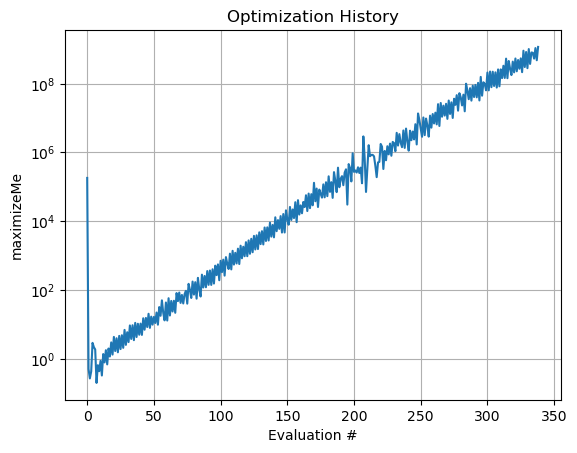

In [ ]:
#Optional: Define list of starting points
totalPopSize = 50  # Total population size
numDimensions = len(bounds)  # Number of parameters

#Uniformly distributed
populationDE = np.random.rand(totalPopSize, numDimensions)
for i in range(numDimensions):
    low, high = bounds[i]
    populationDE[:, i] = low + populationDE[:, i] * (high - low)

#Normally distributed
# populationDE = np.zeros((totalPopSize, numDimensions))
# for i in range(numDimensions):
#     low, high = bounds[i]

#     #Define mean based on bounds
#     #mean = (high + low) / 2

#     #Optional: Define mean based on defaultSettingsVector
#     mean = defaultSettingsVector[i]
    
#     std_dev = (high - low) / 5
#     populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)

#Optional: Add specific points to initial evaluation list
#populationDE = np.vstack([[ np.mean(i) for i in bounds ], populationDE])
#populationDE = np.vstack([[ defaultSettingsVector ], populationDE])

# result = differential_evolution(
#     wrapperDE, 
#     bounds,
#     maxiter=1000, 
#     disp=True,
#     polish = False, 
#     init = populationDE
# )

from scipy.optimize import minimize


#Optional: Manually define starting simplex
# initial_simplex = np.tile(defaultSettingsVector, (numDimensions + 1, 1))
# for i in range(1, numDimensions + 1):
#     initial_simplex[i][i - 1] *= 1.1

result = minimize(
    wrapperDE, 
    defaultSettingsVector,
    method = "Nelder-Mead",
    bounds = bounds,
    #options={'initial_simplex': initial_simplex}
)

# result = minimize(
#     wrapperDE, 
#     defaultSettingsVector,
#     method = "L-BFGS-B",
#     bounds = bounds,
#     #options = {"eps": [0.001*x for x in defaultSettingsVector]}
#     options = {"eps": [0.1 for x in defaultSettingsVector]}
# )

print(problem.history) 